#Initialize this colab notebook

In [8]:
import numpy as np
from scipy.fft import fft2
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from math import log10, floor

The following repository can be cloned if this code is being executed in google colab. This will bring the sample files into the virtual enviornement. If this is being run locally in a jupyter notebook enviorment, just navigate to the sample files. (Might implement another block for this later.



In [10]:
! git clone https://github.com/bbrown11924/Diffraction-Lab-Supplementary.git
%cd Diffraction-Lab-Supplementary

Cloning into 'Diffraction-Lab-Supplementary'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 6.02 KiB | 2.00 MiB/s, done.
/content/Diffraction-Lab-Supplementary


Run this block to make sure the above block worked. You should see image files including 'hex_target.png'

In [11]:
! ls

10cm_hex.jpg  10cm_pi.jpg  hex_target.png  pi_target.png  README.md


#Make an aperture

## Calibration aperture
Real apertures have a thickness that can affect the diffraction pattern you observe if the effective slit width changes as a function of the angle between the light wavefront and the aperture

The following section will help you quantify that effect using a single slit as the calibration tool.

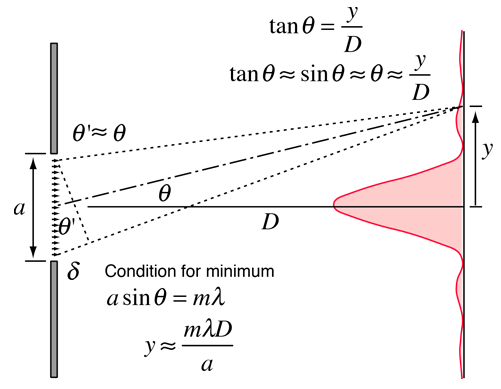

Diagram from: http://hyperphysics.phy-astr.gsu.edu/hbase/phyopt/sinslit.html

In [12]:
wavelength = 632.8E-9 # Insert the value for the wavelength here
d_wavelength = 0.1E-9# Uncertainty in the wavelength

distance_between_fringes = 2.1E-3 # Insert the value for the distance between the fringes here
d_fringes= 0.2E-3 # Uncertainty in the distance between the fringes

distance_from_slit_to_screen = 0.91 # Insert the value for the distance from the slit to the screen here (D in the diagram)
d_screen = 0.01 # Uncertainty in the distance to the screen


# Calculate the width of the slit (a in the diagram)
width = wavelength *  distance_from_slit_to_screen / distance_between_fringes

# Calculate the error in the width of the slit
error = np.sqrt((d_wavelength *  distance_from_slit_to_screen / distance_between_fringes)**2+(wavelength *  d_screen / distance_between_fringes)**2 + ((wavelength *  distance_from_slit_to_screen / distance_between_fringes**2) * d_fringes)**2)

width = width*1E3
error = error*1E3
# Print the width of the slit
print('The width of the slit is {:.{prec}f}({:.0f})mm'.format(width, floor(error / (10**floor(log10(error)))), prec=-floor(log10(error))))

The width of the slit is 0.27(2)mm


## Considerations for non-standard apertures

# FFT calculation
This section will walk you through the derivation of the far-field diffraction pattern and explore the consequences of numerically solved fourier transforms.

First we load in our image. 2 samples are provided, "hex_target.png" and "pi_target.png".  The image also must be a square, and sometimes even if the image was meant to be a square it can be a few pixels off, so we perform a crop. You should be able to see the cropped image after running the next block

(-0.5, 117.5, 117.5, -0.5)

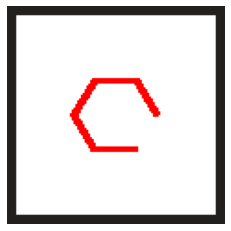

In [21]:
image_filename = "hex_target.png"

# Read and process image
image = Image.open(image_filename).convert('RGB')
image = np.array(image)

#Crop image to be a perfect square
image = image[:, :image.shape[0], :]

plt.set_cmap('gray')
plt.imshow(image)
plt.axis("off")

Now we want to just extract the actual slit from the above image. For the test images this was done by first pushing any range of black colors to white (to get rid of the border) converting to greyscale. 

You could either design your slit images like ours or modify the function below to give the same results.

(-0.5, 117.5, 117.5, -0.5)

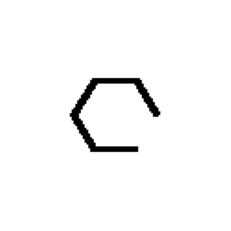

In [22]:
#This is basically a black threshold
r1, g1, b1 = 40, 40, 40 # Original value

red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2]
mask = (red <= r1) & (green <= g1) & (blue <= b1)
image[:,:,:3][mask] = [255, 255, 255]


image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

plt.set_cmap('gray')
plt.imshow(image)
plt.axis("off")

Finally we can calculate the fft of this image

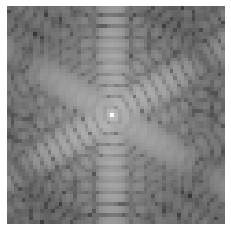

In [23]:
def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

#Calculate the fft
ft = calculate_2dft(image)

#Flip the fft so it visually matches 
ft = np.flip(ft, axis=1)

plt.xlim(ft.shape[0]/4, 3*ft.shape[0]/4)
plt.ylim(ft.shape[1]/4, 3*ft.shape[1]/4)

c = plt.imshow(np.log(abs(ft)), vmin=0, vmax=15)
#plt.colorbar(c)
plt.axis("off")
plt.show()

# Import your actual diffraction pattern

In [ ]:
from google.colab import files
uploaded = files.upload()

# Calculate the entropy from the diffraction patterns
This section will show you how to take an image (either from your computationally determined diffraction pattern or your actual diffraction pattern) and calculate the entropy.

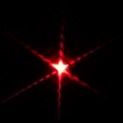

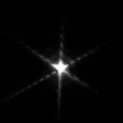

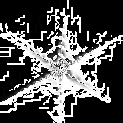

The total number of pixels in the image is:  15129
The entropy of this diffraction pattern is:  7400447.618652344
Entropy (bits/pixel) =  489.15642928497215


In [24]:
dif_pattern = cv2.imread('10cm_hex.jpg')        # Open original diffraction image
gray_dif = cv2.cvtColor(dif_pattern, cv2.COLOR_BGR2GRAY)
cv2.imwrite('Grayscaled_square.jpg', gray_dif)       # Save grayscaled diffraction image

cv2_imshow(dif_pattern)   # Show original diffraction image
cv2_imshow(gray_dif)      # Show grayscaled diffraction image but it's not used in this code for calculation

kernelx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) #Sobel filter for x gradient
kernely = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]]) #Sobel filter for y gradient

xconv = ndimage.convolve(gray_dif, kernelx) #Convolving with the image to calculate the gradient along each direction
yconv = ndimage.convolve(gray_dif, kernely)

sobel = np.hypot(xconv, yconv) #Calculating the total gradient for each pixel

cv2_imshow(sobel) #Plotting


S_entropy = 0
counts = 0

for y in range(len(sobel)):
  for x in range(len(sobel[y])):
    pixel = sobel[y][x]
    counts += 1
    if pixel == 0:
        S_entropy += 0
    else:
        S_entropy += pixel * np.log(pixel)

print('The total number of pixels in the image is: ', counts)
print('The entropy of this diffraction pattern is: ', S_entropy)
print('Entropy (bits/pixel) = ', S_entropy/counts)

# Comparisons and Conclusions